In [1]:
# file specific libraries
import torch
import pandas as pd 
import numpy as np

In [2]:
import sys
sys.path.append('../')
from GNN import *
from train_mask import *
from data import *

In [3]:
# ## training & evaluating 
# from sklearn.metrics import confusion_matrix
# from sklearn.decomposition import PCA
# import torch.nn.functional as F
# import torch.nn
# import matplotlib.pyplot as plt

# class accuracy():
#     def __init__(self, model, device, dataset, data, indicate=True):
#         self.model = model(attributes=dataset.num_node_features, classes=dataset.num_classes, dimension=32).to(device)
#         self.data = data
#         self.indicate = indicate
    
#     def train(self, num_epochs, lr=0.001):
#         loss_vals= []
#         valid_vals= []
#         optimizer = torch.optim.Adam(self.model.parameters(), lr, weight_decay=5e-4)
#         if self.indicate: print(f'Training the model')

#         ## training 
#         for epoch in range(num_epochs): 
#             optimizer.zero_grad() 

#             out = self.model(self.data)
#             loss = F.cross_entropy(input=out[self.data.train_mask], target=self.data.y[self.data.train_mask]) 
#             loss.backward() 
#             optimizer.step() 
#         if self.indicate: print(f'Training Completed')
            
#     def evaluate(self, dimension=1, write_confusion=False, return_prediction=False):
#         # returns a confusion matrix if set write_confusion=True
#         if self.indicate: print('Evaluating the model')
#         self.model.eval()
#         pred = self.model(self.data).argmax(dimension)        
#         correct = (pred[self.data.test_mask] == self.data.y[self.data.test_mask]).sum()
#         acc = int(correct) / int(self.data.test_mask.sum())
        
#         if self.indicate: print(f'Accuracy: {acc:.4f}')
        
#         if write_confusion: 
#             new = confusion_matrix(self.data.y[self.data.test_mask].numpy(), pred[self.data.test_mask].numpy(), normalize='true')
#             if return_prediction: 
#                 return pd.DataFrame(data=new), pred[self.data.test_mask], acc
#             else: return pd.DataFrame(data=new), acc
#         else:
#             if return_prediction: 
#                 return pred[self.data.test_mask], acc
#         return None, acc
    

In [4]:
def return_accuracy(model, dataset, data, epoch_size, original_output=None, indicate=False, return_prediction=False, compute_gradient=False):
    """
    original_output = output using the original data, optional
    indicate = Boolean
    compute_gradient = Boolean
    
    returns: prediction by the given data, gradients if comput_gradient set True, accuracy of the model trained using the given data 
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    new_class = accuracy(model, device, dataset, data, indicate=indicate)              
    new_class.train(epoch_size)
    new_output, new_accuracy = new_class.evaluate(return_prediction=return_prediction)
    new_accuracy = round(new_accuracy,3)
    new_output = torch.Tensor.float(new_output)
    if compute_gradient: 
        if len(new_output) != len(original_output): gradients = None
        else: gradients = torch.nn.functional.softmax(original_output-new_output, dim=0).numpy()
    else: gradients = None
        
    return new_output, gradients, new_accuracy

In [55]:
import time, math
from copy import deepcopy

class find_the_influential_class(): 
    """
    given a dataset, mask each node at a time and compare accuracy to find the most influential point 

    note: the dataset must already have a preexisting train_mask tensor
    note: will only mask the points in the current train_mask 
    """
    
    def __init__(self, model, dataset, epoch_size):
        self.model = model
        self.dataset = dataset
        self.epoch_size = epoch_size
        self.output, _, self.init_accuracy = return_accuracy(model, dataset, dataset[0], epoch_size, return_prediction=True, indicate=False)
        self.accuracy = deepcopy(self.init_accuracy)
        self.influential = {}
        self.gradients = {}
    
    def influential_accuracy(self, indicate=False, record_time=True, index_range=True, compute_gradient=False):
        
        ##question: integer = integer; would this be equal or a copy?
        
        start_time = time.time()
        data = self.dataset[0]
        train_mask = data.train_mask.numpy()
        print(f"\ninitial accuracy given the initial data: {self.init_accuracy}")

        # calculate new accuracy and update "influential" if it improves the accuracy 
        leng = len(data.x)
        for i in range(leng): 
            if train_mask[i]:
                if indicate: print(f"\n--Masking: Excluding point number {i}--")
                data = mask_a_node(self.dataset, i)
                _, gradients, new_accuracy = return_accuracy(self.model, self.dataset, data, self.epoch_size, torch.Tensor.float(self.output), return_prediction=True, indicate=indicate, compute_gradient=compute_gradient)
                if new_accuracy >= self.accuracy: 
                    self.accuracy = new_accuracy
                    self.influential[i] = new_accuracy
                    self.gradients[i] = gradients
                
        if record_time: print("--- %s seconds ---" % round((time.time() - start_time), 1))
        if index_range: print(f"lowest accuracy: {self.init_accuracy}, highest accuracy: {self.accuracy}, range: {self.accuracy-self.init_accuracy}")
        
        global percentage_df
        percentage_df = pd.DataFrame(index=self.influential.keys())
        return self.influential, self.gradients  
                
    #post processing methods
    def top25(self): ## print the upper 75th percentile
        leng = len(self.influential)
        print(leng)
        top25 = math.floor(leng* 0.75) #rounding down in case there are only one or two influential points
        influence_index = list(self.influential.keys())[top75:]
        print(f"{leng} influential points, 75th percentiles: ")
        for i in influence_index: 
            print(f"node {i}, accuracy: {self.influential[i]}")

    def to_percentage(self): ## use softmax to update influencial.values() to softmax percentage
        for key, value in self.influential.items(): 
            self.influential[key] = round((value-self.init_accuracy)/value,2)*100
                
    # display results
    def display_accuracy(self):
        percentage_df['accuracy'] =  self.influential.values()
        display(percentage_df)
    
    def display_gradients(self):
        print(f"Total influential points: {len(self.influential)}, in ascending order of accuracy:")
        for node, gradients in self.gradients.items():
            print(f"Node {node}: \n - accuracy improves to {self.influential[node]}% \n - gradients: {gradients}'")

    def display_percentage(self):    
        percentage_df['accuracy improvement [%]'] = self.influential.values()    
        display(percentage_df)
#             print(f"masking node {key} increases the prediction accuracy by {self.influential[key]}%")

In [22]:
new = find_the_influential_class(GraphSAGE, cora_P, 1)
new.influential_accuracy(indicate=True, compute_gradient = True)


initial accuracy given the initial data: 0.132

--Masking: Excluding point number 0--
Training the model
Training Completed
Evaluating the model
Accuracy: 0.0737

--Masking: Excluding point number 1--
Training the model
Training Completed
Evaluating the model
Accuracy: 0.2974

--Masking: Excluding point number 2--
Training the model
Training Completed
Evaluating the model
Accuracy: 0.0974

--Masking: Excluding point number 3--
Training the model
Training Completed
Evaluating the model
Accuracy: 0.1482

--Masking: Excluding point number 4--
Training the model
Training Completed
Evaluating the model
Accuracy: 0.2842

--Masking: Excluding point number 5--
Training the model
Training Completed
Evaluating the model
Accuracy: 0.2974

--Masking: Excluding point number 6--
Training the model
Training Completed
Evaluating the model
Accuracy: 0.0974

--Masking: Excluding point number 7--
Training the model
Training Completed
Evaluating the model
Accuracy: 0.1439

--Masking: Excluding point numb

({1: 0.297,
  5: 0.297,
  12: 0.297,
  16: 0.297,
  25: 0.297,
  30: 0.297,
  33: 0.297,
  44: 0.297,
  59: 0.297,
  67: 0.297,
  80: 0.304,
  90: 0.31},
 {1: array([0.00087719, 0.00087719, 0.00087719, ..., 0.00087719, 0.00087719,
         0.00087719], dtype=float32),
  5: array([0.00087719, 0.00087719, 0.00087719, ..., 0.00087719, 0.00087719,
         0.00087719], dtype=float32),
  12: array([0.00087719, 0.00087719, 0.00087719, ..., 0.00087719, 0.00087719,
         0.00087719], dtype=float32),
  16: array([0.00087719, 0.00087719, 0.00087719, ..., 0.00087719, 0.00087719,
         0.00087719], dtype=float32),
  25: array([0.00087719, 0.00087719, 0.00087719, ..., 0.00087719, 0.00087719,
         0.00087719], dtype=float32),
  30: array([0.00087719, 0.00087719, 0.00087719, ..., 0.00087719, 0.00087719,
         0.00087719], dtype=float32),
  33: array([0.00087719, 0.00087719, 0.00087719, ..., 0.00087719, 0.00087719,
         0.00087719], dtype=float32),
  44: array([0.00087719, 0.00087719,

In [23]:
table = pd.DataFrame()
table['accuracy'] = new.influential.values()
table

,accuracy
0,0.297
1,0.297
2,0.297
3,0.297
4,0.297
5,0.297
6,0.297
7,0.297
8,0.297
9,0.297


In [24]:
new.display_accuracy()
new.display_gradients()

,accuracy
1,0.297
5,0.297
12,0.297
16,0.297
25,0.297
30,0.297
33,0.297
44,0.297
59,0.297
67,0.297


Total influential points: 12, in ascending order of accuracy:
Node 1: 
 - accuracy improves to 0.297% 
 - gradients: [0.00087719 0.00087719 0.00087719 ... 0.00087719 0.00087719 0.00087719]'
Node 5: 
 - accuracy improves to 0.297% 
 - gradients: [0.00087719 0.00087719 0.00087719 ... 0.00087719 0.00087719 0.00087719]'
Node 12: 
 - accuracy improves to 0.297% 
 - gradients: [0.00087719 0.00087719 0.00087719 ... 0.00087719 0.00087719 0.00087719]'
Node 16: 
 - accuracy improves to 0.297% 
 - gradients: [0.00087719 0.00087719 0.00087719 ... 0.00087719 0.00087719 0.00087719]'
Node 25: 
 - accuracy improves to 0.297% 
 - gradients: [0.00087719 0.00087719 0.00087719 ... 0.00087719 0.00087719 0.00087719]'
Node 30: 
 - accuracy improves to 0.297% 
 - gradients: [0.00087719 0.00087719 0.00087719 ... 0.00087719 0.00087719 0.00087719]'
Node 33: 
 - accuracy improves to 0.297% 
 - gradients: [0.00087719 0.00087719 0.00087719 ... 0.00087719 0.00087719 0.00087719]'
Node 44: 
 - accuracy improves to 0.2

## distribution plot

In [67]:
# a list of weights of each influential point 
# a list of y differences 
# multipled the two lists 

# any particular neighbours of the influential points that are significantly impacted by the removal of such points 
# sum of weighted graadients and plot them 
# or I can plot per node 

# a list of influential nodes, output given which node 
# which prediction within the output is heavily impacted by the influential node 

import matplotlib.pyplot as plt

def distribution_plot(influential_class):
    """
    note: only returns if stdev of the output differences is higher than zero
    prints a multi-line graph that graphs 
    """
    # preprocessing
    influential_class.to_percentage()

    # 1. processes all accuracy improvements of each influential points using softmax
    influence = []
    for value in influential_class.influential.values():
        influence.append(value)
    influence = torch.FloatTensor(influence)
    influential_percentage = torch.nn.functional.softmax(influence, dim=0).numpy()
    influential_percentage = np.round(influential_percentage, 3)
 
    adjusted_influences = {}
    keys = list(influential_class.influential.keys())
    for i in range(len(keys)):
        adjusted_influences[keys[i]] = influential_percentage[i]

    #2. scales the output difference of each influential point by the accuracy 
    # improvements of each influential points 
    adjusted_gradients = {} 
    heavily_affected_nodes = {}
    
    for node, gradient_list in influential_class.gradients.items():
        if gradient_list.all() != None:
            stdev = gradient_list.std()
            if stdev!=0: 
                average = gradient_list.mean()
                heavily_affected_nodes[node] = {'stdev':stdev}
                nodes = []
                for i in range(len(gradient_list)): 
                    if gradient_list[i] > average + stdev:
                        nodes.append(i)
                if len(nodes) <2: 
                    nodes.append(None)
                heavily_affected_nodes[node]['nodes'] = nodes
                if node in adjusted_gradients.keys():
                    adjusted_gradients[node] += influential_class.influential[node] * adjusted_influences[node] * gradient_list
                else: 
                    adjusted_gradients[node] = influential_class.influential[node] * adjusted_influences[node] * gradient_list

    ## print 
#     print(heavily_affected_nodes)
    for node, items in heavily_affected_nodes.items(): 
        print(f"node {node}'s exclusion leads to {influential_class.influential[node]}% accuracy improvement")
        print(f"standard deviation of output difference is {heavily_affected_nodes[node]['stdev']}")
        print(f"most affected nodes by the influential node(s) is/are {heavily_affected_nodes[node]['nodes']}\n")
     
#     for i in adjusted_gradients.keys(): print(i, adjusted_gradients[i])
    
    for gradient in adjusted_gradients.values():
        if gradient.all() != None:
            leng = len(list(adjusted_gradients.values())[0])
            for i in adjusted_gradients.keys():
                plt.plot(list(range(leng)), adjusted_gradients[i], label = i, linestyle="-")
    plt.show
    
    return heavily_affected_nodes

    
#     df = pd.DataFrame(index=influential_class.influential.keys(), 
#                       columns=['accuracy improvement [%]', 'stdev ', 'most affected nodes']    
#     df['accuracy improvement [%]'] = self.influential.values()
#     df['stdev of output difference'] = 

node 80's exclusion leads to 100.0% accuracy improvement
standard deviation of output difference is 0.0010017529129981995
most affected nodes by the influential node(s) is/are [3, 9, 41, 52, 54, 58, 96, 102, 124, 125, 126, 133, 135, 161, 166, 174, 181, 200, 201, 204, 210, 216, 239, 264, 275, 288, 324, 372, 375, 482, 501, 502, 512, 520, 521, 522, 524, 530, 531, 553, 567, 575, 582, 598, 599, 605, 618, 627, 635, 639, 641, 643, 650, 704, 706, 709, 711, 721, 730, 762, 763, 779, 793, 803, 804, 805, 834, 840, 845, 854, 858, 860, 875, 878, 884, 901, 921, 925, 936, 943, 991, 1023, 1069, 1070, 1071, 1091, 1096, 1101]

node 90's exclusion leads to 100.0% accuracy improvement
standard deviation of output difference is 0.0004538492939900607
most affected nodes by the influential node(s) is/are [1, 12, 16, 31, 36, 38, 50, 53, 63, 64, 73, 82, 88, 89, 94, 95, 98, 105, 109, 111, 112, 113, 121, 125, 133, 134, 135, 136, 137, 140, 146, 149, 151, 152, 156, 160, 162, 163, 165, 166, 169, 170, 171, 172, 174, 

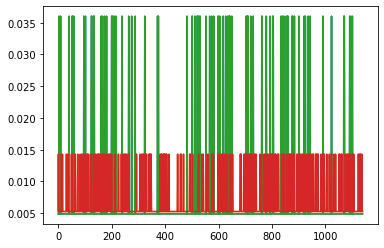

In [68]:
affected_nodes = distribution_plot(new)

In [71]:
for i in affected_nodes[80]['nodes']:
    print(new.gradients[80][i])

print(new.gradients[80])

0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874
0.0043407874

In [ ]:
# look at the neighbours of individual influential nodes

## issues: 
- RuntimeError: The size of tensor a (1083) must match the size of tensor b (1084) at non-singleton dimension 0
- if a point very early in the set is one of the highest influences, then the function will return only couple of points as influential points. 
- output length doesn't match with data.y's length? what is the size of the gradients' meaning? 

In [ ]:
print(len(cora_P[0].train_mask))

In [ ]:
count = 0 
for i in cora_P[0].train_mask: 
    if i: count +=1 
print(count)

In [ ]:
cora_P[0].y

In [ ]:
print((len(new.gradients[0])))